# Project work

## TASKS
- Explorative analysis
    - Data cleaning
    - Basic statistics
    - Figuring out which measures are important
- Statistical Tests
    - Estimation about parameter(s) that best represent the population
    - Hyphothese and its testing
- Must do a statistical model

## Reviewing criteria
- Data preparation
- Use of descriptive statistics
- Use of estimation and statistical test
- Argumentation for design choices
- interpretation of results

## Tasks from the hypothetical scheme
1. Characterise the individuals that are present in the data. Are there groups of similar persons?
    - Distributions for all categorical values
    - Find out if certain age, sex, and municipality groups have similiar activities
2. Estimate how much time on average households spend daily on each activity.
    - try out mean and medians for activities
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?
5. Which activities are associated with each other?

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # found from online tutorial
# import seaborn as sns



In [70]:
# Loading data
df = pd.read_csv('./habits.data',
                sep=";",
                na_values=["?"],
                index_col=False,
                header=0)

Ikäluokkaryhmiä 1-2 eli alle 20 vuotiaita ei ole tuloksissa ollenkaan
Vastanneiden painopiste intuitiivisesti on jossain luokan 6 kohdalla.
Vastaa intuitiivisesti yläpäähän painottuvaa normaalijakaumaa

### Demographic variables
- kohde - household ID: nominal
- jasen - member ID (within household): nominal
- pvknro - day of week: nominal
    - 1 = working day
    - 2 = weekend

- sp - sex: nominal
    - 1 = male
    - 2 = female
- IKAL1 - age group: ordinal
    - 1 = 10-14 years old
    - 2 = 15-19 years old
    - 3 = 20-24 years old
    - 4 = 25-34 years old
    - 5 = 35-44 years old
    - 6 = 45-54 years old
    - 7 = 55-64 years old
    - 8 = 65-74 years old
    - 9 = 75- years old

- ASALUE - living environment: nominal
    - 1 = city
    - 2 = municipality
    - 3 = rural area

### Activity variables
Time spent on activities (measured in minutes): ratio

- V1 - working: ratio
- V5 - cooking: ratio
- V21 - childcare: ratio
- V22 - reading and playing with children: ratio

Place visited in past 12 months 
- Values: indicator
    - 1 = yes
    - 2 = no

- H1a_A - cinema: indicator
- H1b_A - theater: indicator


## Data preparation

### Initial column deletion

In [71]:
# Keep relevant columns
columns_to_keep = ['kohde', 
                   'jasen', 
                   'pvknro', 
                   'sp', 
                   'IKAL1', 
                   'ASALUE', 
                   'V1', 
                   'V21', 
                   'V22', 
                   'V5', 
                   'H1a_A', 
                   'H1b_A']
df = df[columns_to_keep]
# df

In [72]:
# Renaming columns
df.rename(columns={'kohde': 'Household_id', 
                   'jasen': 'Member_id', 
                   'pvknro': 'Day_of_Week', 
                   'sp': 'Sex', 
                   'IKAL1': 'Age_Group', 
                   'ASALUE': 'Area', 
                   'V1': 't_Working', 'V21': 't_Cooking', 'V22': 't_Childcare', 'V5': 't_Activity_w_Child', 
                   'H1a_A': 'Visited_Cinema', 'H1b_A': 'Visited_Theatre'
                   }, inplace=True)

In [73]:
# print(df.info(), "\n")
# print(df.describe().round(2), "\n")
print(df.isna().sum(),"\n")
# print(df.nunique(), "\n")

Household_id           0
Member_id              0
Day_of_Week            0
Sex                    0
Age_Group              0
Area                   0
t_Working             11
t_Cooking              6
t_Childcare            7
t_Activity_w_Child     5
Visited_Cinema        44
Visited_Theatre       44
dtype: int64 



### Notes from initial data check

- 338 unique household IDs
- Other categorical values have all categories stated in data info
- In non-categoric values there is lots of NaN values. 
- Not taking NaNs in to account the data uniqueness seems ok. 
- At least the lower 25% has 0 minutes in all activities
- Dtypes are not correct


In [74]:
# Testing if there are more than 2 answers per household
one = (df['Household_id'].value_counts().copy() == 1).sum()
two = (df['Household_id'].value_counts().copy() == 2).sum()
over_two = (df['Household_id'].value_counts().copy() > 2).sum()

print("One: {}, Two: {}, Over Two: {}".format(one, two, over_two))

# 11 households have only 1 answer, dropping them
occurrences = df['Household_id'].value_counts().copy()
household_ids = occurrences[occurrences == 1].index

# Dropping households with only 1 answer
df = df[~df['Household_id'].isin(household_ids)].copy()

One: 11, Two: 367, Over Two: 0


### Cleaning columns that show activities visited

In [75]:
# Checking if values are correct
df[['Visited_Cinema', 'Visited_Theatre']].value_counts()

Visited_Cinema  Visited_Theatre
2.0             2.0                217
1.0             1.0                199
2.0             1.0                127
1.0             2.0                121
0.0             0.0                  8
60.0            120.0                2
0.0             60.0                 1
                180.0                1
                300.0                1
60.0            0.0                  1
120.0           0.0                  1
                60.0                 1
                120.0                1
                180.0                1
300.0           0.0                  1
360.0           120.0                1
Name: count, dtype: int64

In [76]:
# 'Visited_Cinema' and 'Visited_Theatre' has NaN values and overly large values etc.
# Change errenoeus to NaN and then delete all rows containing NaN values - Only 1.0 and 2.0 are valid

df['Visited_Cinema'] = df['Visited_Cinema'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)
df['Visited_Theatre'] = df['Visited_Theatre'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)

df.dropna(subset=['Visited_Cinema', 'Visited_Theatre'], inplace=True)
print(df.isna().sum())
# df['Visited_Cinema'].values

Household_id          0
Member_id             0
Day_of_Week           0
Sex                   0
Age_Group             0
Area                  0
t_Working             9
t_Cooking             6
t_Childcare           7
t_Activity_w_Child    4
Visited_Cinema        0
Visited_Theatre       0
dtype: int64


### Cleaning Columns that measure time

In [77]:
drop_err_values = ['t_Working','t_Cooking', 't_Childcare', 't_Activity_w_Child']
for column in drop_err_values:
    df[column] = df[column].apply(
        lambda x: pd.to_numeric(x, errors='coerce')  # Convert to numeric, set invalid to NaN
    )
    df[column] = df[column].fillna(0).astype(int)  # Replace NaN with 0 before conversion



<Axes: ylabel='Frequency'>

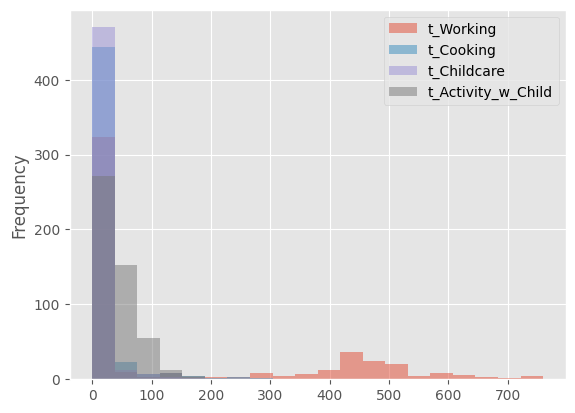

In [78]:
# Time spent in activities
# Check weekend and weekday separately

# There is 164 rows where all times are 0 minutes -> quite a lot 
time_columns = ['t_Working', 't_Cooking', 't_Childcare', 't_Activity_w_Child']
time_df = df[time_columns]
time_df[time_columns].value_counts()

# Checking those that have some time spent in at least one of the activities
time_df[(time_df != 0).any(axis=1)].plot.hist(bins=20, alpha=0.5)



### Retyping data

In [79]:
# Retyping columns
df['Household_id'] = df['Household_id'].astype('int64')
df['Member_id'] = pd.Categorical(df['Member_id'])                       # Categorical
df['Day_of_Week'] = pd.Categorical(df['Day_of_Week'], ordered=True)     # Binary, categorical, 
df['Sex'] = pd.Categorical(df['Sex'])                                   # Categorical   
df['Age_Group'] = pd.Categorical(df['Age_Group'], ordered=True)         # Categorical
df['Area'] = df['Area'].astype('int64')                                 # Categorical, ordered
df['Area'] = pd.Categorical(df['Area'], ordered=True)                   # Categorical, ordered

df['t_Working'] = df['t_Working'].astype('int64')
df['t_Cooking'] = df['t_Cooking'].astype('int64')
df['t_Childcare'] = df['t_Childcare'].astype('int64')
df['t_Activity_w_Child'] = df['t_Activity_w_Child'].astype('int64')



# Deleting NaN values or replacing with 0 -> if replaced, may introduce bias towards not going. 


In [80]:
df.dtypes

Household_id             int64
Member_id             category
Day_of_Week           category
Sex                   category
Age_Group             category
Area                  category
t_Working                int64
t_Cooking                int64
t_Childcare              int64
t_Activity_w_Child       int64
Visited_Cinema          object
Visited_Theatre         object
dtype: object

In [81]:
df

,Household_id,Member_id,Day_of_Week,Sex,Age_Group,Area,t_Working,t_Cooking,t_Childcare,t_Activity_w_Child,Visited_Cinema,Visited_Theatre
0,50002,1,1,1,6,1,0,0,0,0,No,No
1,50002,1,2,1,6,1,380,0,0,10,No,No
2,50003,1,1,2,5,2,0,50,0,60,No,Yes
3,50003,1,2,2,5,2,0,50,0,50,No,Yes
4,50004,2,1,1,7,1,640,0,0,0,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
738,51973,1,2,1,5,2,0,0,0,10,Yes,No
739,51980,1,1,2,6,2,0,0,0,0,Yes,Yes
740,51980,1,2,2,6,2,460,0,0,20,Yes,Yes
743,51983,1,1,2,8,3,0,0,0,40,Yes,No


In [82]:
df.isna().sum()

Household_id          0
Member_id             0
Day_of_Week           0
Sex                   0
Age_Group             0
Area                  0
t_Working             0
t_Cooking             0
t_Childcare           0
t_Activity_w_Child    0
Visited_Cinema        0
Visited_Theatre       0
dtype: int64

### Mapping tool if needed later on

In [83]:
# Tool for mapping the values for better presentation

map_day = {
    1: 'Workday',
    2: 'Weekend'
}

map_sex = {
    1: 'Male',
    2: 'Female'
}

map_age = {
    1: "10-14",
    2: "15-19",
    3: "20-24",
    4: "25-34",
    5: "35-44",
    6: "45-54",
    7: "55-64",
    8: "65-74",
    9: "75+"
}    

map_area = {
    1: "City",
    2: "Municipality",
    3: "Rural"
}

map_cinema = {
    1: "Yes",
    2: "No"
}

map_theatre = {   
    1: "Yes",
    2: "No"
}

mappable_columns = ['Day_of_Week', 'Sex', 'Age_Group', 'Area', 'Visited_Cinema', 'Visited_Theatre']
map_values = [map_day, map_sex, map_age, map_area, map_cinema, map_theatre]

def df_mapper(df, mappable_columns, map_values): 
    for i in range(len(mappable_columns)):
        df[mappable_columns[i]] = df[mappable_columns[i]].map(map_values[i])
    return df

# Copy enables to run again
df_copy = df.copy()
df_mapped = df_mapper(df_copy, mappable_columns, map_values)


<Axes: xlabel='Minutes', ylabel='Frequency'>

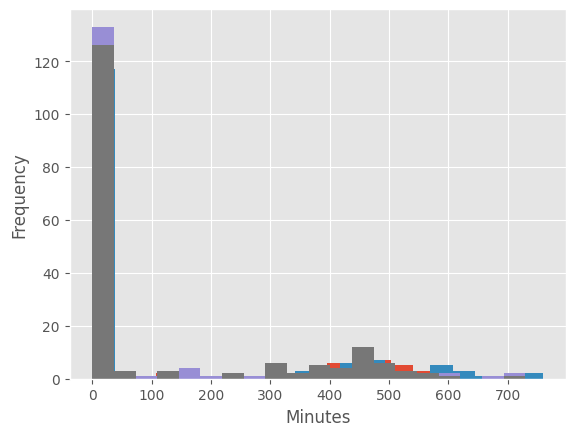

In [84]:
# If I want to see only males -> select Day_of_Week[Workday OR Weekday] AND Sex[Male OR Female]
female_workday = df_mapped[(df_mapped['Day_of_Week'] == 'Workday') & (df_mapped['Sex'] == 'Female')].sort_values('Age_Group')
female_weekend = df_mapped[(df_mapped['Day_of_Week'] == 'Weekend') & (df_mapped['Sex'] == 'Female')].sort_values('Age_Group')
male_workday = df_mapped[(df_mapped['Day_of_Week'] == 'Workday') & (df_mapped['Sex'] == 'Male')].sort_values('Age_Group')
male_weekend = df_mapped[(df_mapped['Day_of_Week'] == 'Weekend') & (df_mapped['Sex'] == 'Male')].sort_values('Age_Group')

male_weekend['t_Working'].plot.hist(bins=20, xlabel='Minutes')
male_workday['t_Working'].plot.hist(bins=20, xlabel='Minutes')
female_weekend['t_Working'].plot.hist(bins=20, xlabel='Minutes')
female_workday['t_Working'].plot.hist(bins=20, xlabel='Minutes')

### Questions that arises?

- Group differences
    - Working
    - Not working
    - Not working & caring child
    - Different age groups
    - Men and Women

- Member ID seems quite irreleveant, unless there is significant behaviour change in them

### Categorical variables characteristics

TypeError: no numeric data to plot

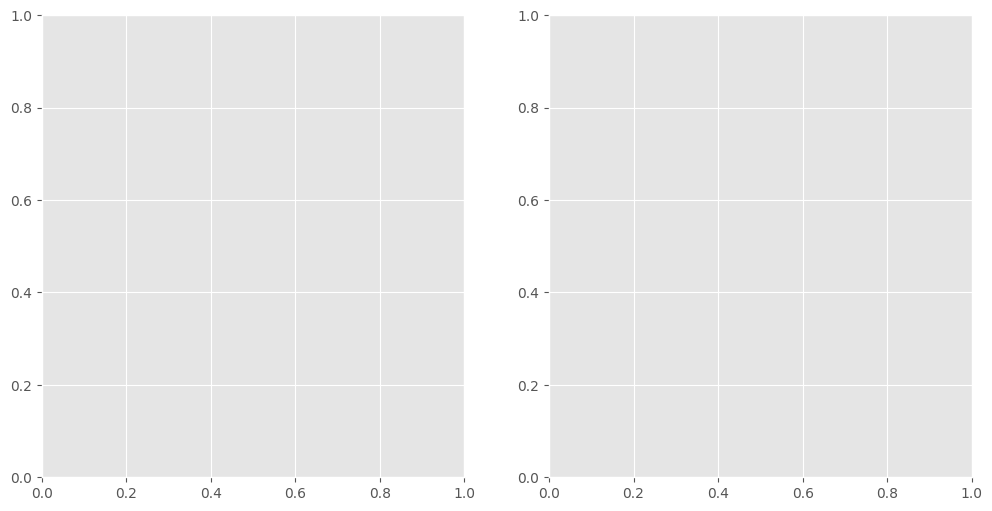

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df['Age_Group'].plot(kind='hist', bins=20, ax=axes[0], title='Histogram of IKAL1')

# Density plot

df['Age_Group'].dropna().sort_values().plot(kind='density', ax=axes[1], title='Density Plot of ')

# plt.tight_layout()
# plt.show()

In [1498]:
# df = df.apply(pd.to_numeric, errors='coerce')
# print(df.sum(axis=0).sort_values(ascending=False), end="\n\n")

173


C:\Users\Arde\AppData\Local\Temp\ipykernel_32920\4220288314.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_sex_counts = mapped_df.groupby(['Area', 'Sex']).size().unstack().copy()


[Text(0, 0, 'City'), Text(1, 0, 'Municipality'), Text(2, 0, 'Rural')]

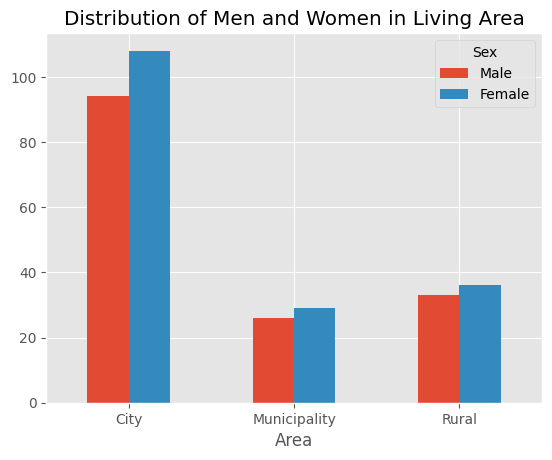

In [1499]:
# Living area distribution
mapped_df = df_mapper(df.copy(), mappable_columns, map_values)
counts = mapped_df['Area'].value_counts().copy()

women_count = (mapped_df.drop_duplicates(subset='Household_id')['Sex'] == 'Female').sum()
print(women_count)
area_sex_counts = mapped_df.groupby(['Area', 'Sex']).size().unstack().copy()
axis3 = (area_sex_counts / 2).plot(kind='bar', title='Distribution of Men and Women in Living Area')
axis3.set_xticklabels(axis3.get_xticklabels(), rotation=0)
   



In [1500]:
# Filter the dataframe to include only rows where Day_of_Week is 1
df_workday = df[df['Day_of_Week'] == 2].copy()

# Convert to numeric
df_scatter_workday = df_workday.apply(pd.to_numeric, errors='coerce')

# Select the columns to normalize (columns 5 to 9)
columns_to_normalize = df_scatter_workday.columns[5:10]

# Apply the rank method to normalize to percentiles
df_scatter_workday[columns_to_normalize] = df_scatter_workday[columns_to_normalize].rank(pct=True)

# Ensure 'Visited_Theatre' is of type int64
df_scatter_workday['Visited_Theatre'] = df_scatter_workday['Visited_Theatre'].astype('int64')

# Plot the scatter matrix
scatter_matrix = pd.plotting.scatter_matrix(df_scatter_workday.iloc[:, 4:10], figsize=(10, 10))


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [892]:
df.dtypes
# series = pd.Series(df['t_Activity_w_Child'])
# series
# df['t_Activity_w_Child']
# series = df['t_Childcare']
# series = df['t_Working']
# series = df['t_Cooking']
# (series - series.mean() / series.std()).plot.hist(bins=20, xlabel='Minutes')

Household_id            int64
Member_id               int64
Day_of_Week             int64
Sex                     int64
Age_Group               int64
Area                    int64
t_Working              object
t_Cooking              object
t_Childcare            object
t_Activity_w_Child     object
Visited_Cinema        float64
Visited_Theatre       float64
dtype: object

In [840]:
# Plot distributions of categorical variables

categorical_columns = ['Day_of_Week', 'Sex', 'Age_Group', 'Area']  # Day of week, Sex, Age, Area

# Create subplots for each categorical variable
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Loop through each categorical column and plot its distribution
# for i, column in enumerate(categorical_columns):
#     ax = axes[i//2, i%2]  # Organize subplots
#     df_mapped[column].value_counts().plot(kind='bar', ax=ax)
#     ax.set_title(f'Distribution of {column}')
#     ax.set_xlabel(column)
#     ax.set_ylabel('Count')
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotate x-axis labels (make them horizontal)



<class 'pandas.core.frame.DataFrame'>
Index: 734 entries, 0 to 744
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Household_id        734 non-null    int64 
 1   Member_id           734 non-null    int64 
 2   Day_of_Week         734 non-null    int64 
 3   Sex                 734 non-null    int64 
 4   Age_Group           734 non-null    int64 
 5   Area                734 non-null    int64 
 6   t_Working           723 non-null    object
 7   t_Cooking           728 non-null    object
 8   t_Childcare         727 non-null    object
 9   t_Activity_w_Child  729 non-null    object
 10  Visited_Cinema      734 non-null    bool  
 11  Visited_Theatre     734 non-null    bool  
dtypes: bool(2), int64(6), object(4)
memory usage: 64.5+ KB


,Household_id,Member_id,Day_of_Week,Sex,Age_Group,Area
count,734.00,734.00,734.0,734.00,734.00,734.00
mean,51017.99,1.36,1.5,1.52,6.10,1.58
std,587.43,0.48,0.5,0.50,1.59,0.82
min,50002.00,1.00,1.0,1.00,3.00,1.00
25%,50518.50,1.00,1.0,1.00,5.00,1.00
50%,51053.00,1.00,1.5,2.00,6.00,1.00
75%,51535.25,2.00,2.0,2.00,7.00,2.00
max,51983.00,2.00,2.0,2.00,9.00,3.00


Household_id           0
Member_id              0
Day_of_Week            0
Sex                    0
Age_Group              0
Area                   0
t_Working             11
t_Cooking              6
t_Childcare            7
t_Activity_w_Child     5
Visited_Cinema         0
Visited_Theatre        0
dtype: int64

In [844]:
# df.duplicated().sum()
# df.loc[df.duplicated()]
# len(df.loc[df.duplicated(subset=['Household_id'])]) * 2
df.groupby('Household_id')['Member_id'].nunique()

# ~df.duplicated(subset=['Household_id']).sum() 

Household_id
50002    1
50003    1
50004    1
50005    1
50006    1
        ..
51971    1
51973    1
51980    1
51981    1
51983    1
Name: Member_id, Length: 367, dtype: int64

Household_id          367
Member_id               2
Day_of_Week             2
Sex                     2
Age_Group               7
Area                    3
t_Working              80
t_Cooking              38
t_Childcare            25
t_Activity_w_Child     30
Visited_Cinema          2
Visited_Theatre         2
dtype: int64

In [846]:
df.sort_values(by='IKAL1', ascending=False).head(5)

KeyError: 'IKAL1'

### Data cleaning
At first glance NaN-values will be dropped, but may change over the study if effect on results seem good either way. 

At first I thought of filling zero values with mean or medians but they would heavily influence the results pushing up correlation and other metrics. It seems that particioners have deliberatley chosen 0 minutes and therefore they are not active on these metrics at all. This must be included in the results.

In [101]:
df_filtered = df.dropna()
# Drop rows with more than 1 zero
#df_filtered = df_filtered[df_filtered.apply(lambda x: (x == 0).sum() < 2, axis=1)]
# Replace zeros with mean values
#df_filled_mean = df_filtered.apply(lambda x: x.replace(0, x.mean()) if x.name in df_filtered.columns else x)
# Replace zeros with median values
#df_filled_median = df_filtered.apply(lambda x: x.replace(0, x.median()) if x.name in df_filtered.columns else x)
len(df_filtered)

668

<Axes: title={'center': 'Density Plot of '}, ylabel='Density'>

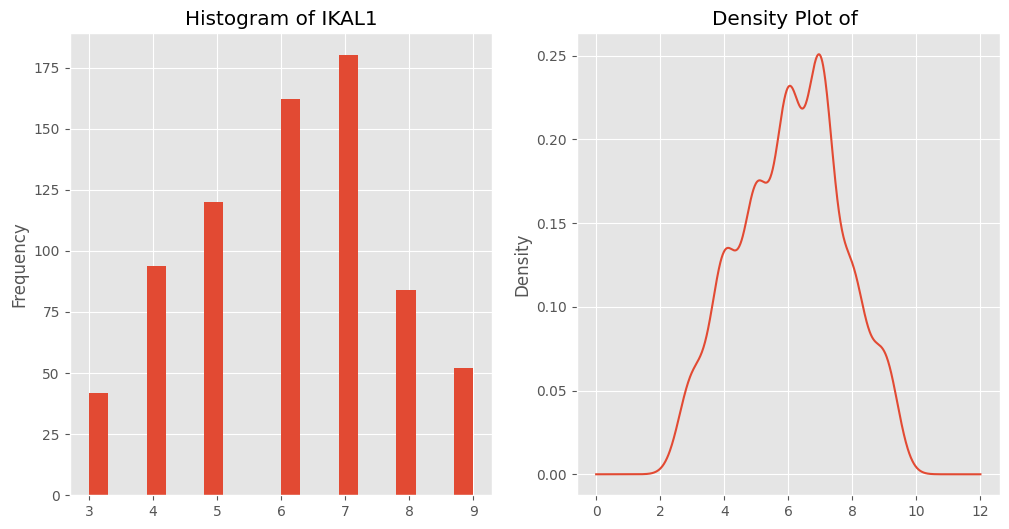

### Correlation

Overall could be assumed that age, sex and region will group particioners similiarly.

Correlations still are quite low generally with max values at around 0.43 and -0.27

In [106]:
# Needs to be done with numeric data only
df.corr().where(lambda x: (x < -0.2) | (x > 0.2)).round(3)

# Measured in minutes
# V1 - working
# V5 - cooking
# V21 - childcare
# V22 - reading and playing with children

# 1 = yes, 2 = no   
# H1a_A - cinema
# H1b_A - theater

ValueError: could not convert string to float: '00:00'

In [47]:
# Counting individual values in column 'jasen' and testing if errors
one, two, faults = 0, 0, 0
fault_values = []
count = len(df_filtered.jasen)

for value in df.jasen.values:
    if value == 1:
        one += 1
    elif value == 2:
        two += 1 
    else:
        print(value)
        fault_values.append(value)
        
if count != one + two:
    print("Error in counting")

print(f" 1's: {one}\n", f"2's: {two}\n", f"Total count: {count}\n", f"Fault values: {fault_values}")

Error in counting
 1's: 478
 2's: 267
 Total count: 601
 Fault values: []
